### 3.2.2 准备数据

In [39]:
# 1. 导入必要的模块
import numpy as np
import torch
# 导入 PyTorch 内置的 mnist 数据
from torchvision.datasets import mnist
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入 nn 及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [40]:
from tensorboardX import SummaryWriter

In [43]:
# 2. 定义一些超参数
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [44]:
# 3. 下载数据并对数据进行预处理 
# 定义预处理函数，这些预处理一次放在 Compose 函数中
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [37]:
# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=False)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)

In [45]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [35]:
type(train_dataset)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [46]:
# dataloader 是一个可迭代对象，可以使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [49]:
train_loader

### 3.2.3 可视化源数据

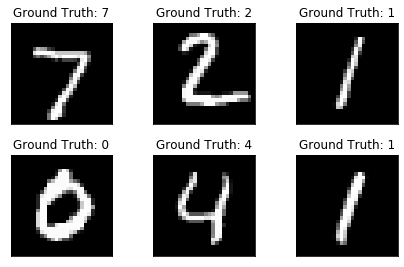

In [10]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# plt.show()

### 3.2.4 构建模型

In [11]:
# 1) 构建网络
class Net(nn.Module):
    '''
    使用 sequential 构建网络，Sequential() 函数的功能是将网络的层组合到一起
    '''
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [12]:
lr = 0.01
momentum = 0.9

In [13]:
# 2) 实例化网络
# 检查是否有可用的 GPU，有则使用，否则使用 CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs")
#         # dim = 0[20, xxx] --> [10, ...], [10, ...] on 2GPUs
#         model = nn.DataParallel(model)
# 实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

### 3.2.5 训练模型

In [16]:
# 1. 训练模型
losses = []
acces = []
eval_losses = []
eval_acces = []

writer = SummaryWriter(log_dir='logs4', comment='train-loss')

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上验证效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}' 
          .format(epoch, train_loss/len(train_loader), train_acc/len(train_loader), 
                  eval_loss/len(test_loader),eval_acc/len(test_loader)))


epoch: 0, Train Loss: 2.1235, Train Acc: 0.2621, Test Loss: 1.8898, Test Acc: 0.4648
epoch: 1, Train Loss: 1.7546, Train Acc: 0.5520, Test Loss: 1.5997, Test Acc: 0.6526
epoch: 2, Train Loss: 1.5199, Train Acc: 0.6861, Test Loss: 1.4002, Test Acc: 0.7457
epoch: 3, Train Loss: 1.3599, Train Acc: 0.7507, Test Loss: 1.2536, Test Acc: 0.7842
epoch: 4, Train Loss: 1.2390, Train Acc: 0.7833, Test Loss: 1.1467, Test Acc: 0.8141
epoch: 5, Train Loss: 1.1842, Train Acc: 0.7957, Test Loss: 1.1370, Test Acc: 0.8124
epoch: 6, Train Loss: 1.1741, Train Acc: 0.7990, Test Loss: 1.1215, Test Acc: 0.8086
epoch: 7, Train Loss: 1.1651, Train Acc: 0.8009, Test Loss: 1.1175, Test Acc: 0.8149
epoch: 8, Train Loss: 1.1568, Train Acc: 0.8018, Test Loss: 1.1172, Test Acc: 0.8182
epoch: 9, Train Loss: 1.1472, Train Acc: 0.8042, Test Loss: 1.1055, Test Acc: 0.8170
epoch: 10, Train Loss: 1.1426, Train Acc: 0.8058, Test Loss: 1.0951, Test Acc: 0.8195
epoch: 11, Train Loss: 1.1417, Train Acc: 0.8063, Test Loss: 1.0

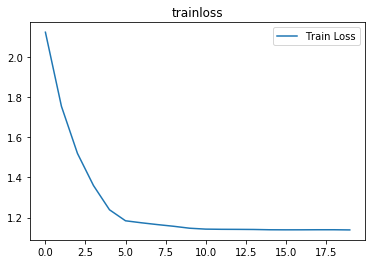

In [17]:
# 2. 可视化训练及测试损失值
plt.title('trainloss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc = 'upper right')

## 3.6 动态修改学习率参数

In [18]:
for epoch in range(num_epoches):
# 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
        print(optimizer.param_groups[0]['lr'])

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12


## 3.7 优化器比较


In [19]:
# 1) 导入需要的模块
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

In [20]:
# 2) 生成数据
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变为二维，torch 只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
# 0.1 * torch.normal(x.size()) 增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))

torch_dataset = Data.TensorDataset(x,y)
# 得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [21]:
# 3) 构建神经网络
class Net(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [22]:
# 4) 使用多种优化器
net_SGD      = Net()
net_Momentum = Net()
net_RMSProp  = Net()
net_Adam     = Net()

nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]

opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp     = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

In [23]:
# 5) 训练模型
loss_func = torch.nn.MSELoss()
loss_his = [[], [], [], []]     # 记录损失
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt, l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x) # Get output for every net
            loss = loss_func(output, batch_y) # Compute loss for every net
            opt.zero_grad() # Clear gradients for next train
            loss.backward() # Backpropagation, compute gradients
            opt.step() # Apply gradients
            l_his.append(loss.data.numpy()) # Loss recoder
labels = ['SGD', 'Momentum', 'RMSProp', 'Adam']

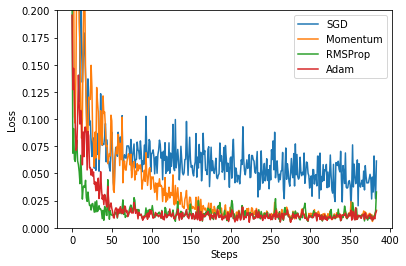

In [24]:
# 6) 可视化结构
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()